In [2]:
%load_ext cython
%load_ext line_profiler
import line_profiler

In [6]:
%%cython -I E:/work_projects/graphlets/graphlet_pyFramework --compile-args=-fopenmp --link-args=-fopenmp --force --cplus
"Here ssorting nobins trying"

cimport numpy as np
import numpy as np
import time
from cython.parallel import prange
cimport cython
from cpython cimport array
import array
import sys
cimport openmp
from collections import OrderedDict


# @cython.boundscheck(False)
cdef int compareA(int a,int b,int [:]comp,bint fromSmall) nogil:
    return (comp[a]-comp[b])*(fromSmall+(-1*(1-fromSmall)))
# @cython.boundscheck(False)
cdef void merge(int[:] a,int lena,int [:] comp,int[:] newA,bint fromSmall) nogil:
    if lena<=1:
        return
    cdef int right=lena//2
    cdef int left=lena-right
    merge(a[:left],left,comp,newA[:left],fromSmall)
    merge(a[left:],right,comp,newA[left:],fromSmall)
   
#     print '!!! merged',np.asarray(left) ,np.asarray(right) ,np.asarray(a),np.asarray(newA)
    combinetwo(a[:left],left,a[left:],right,comp,newA,fromSmall)
    a[:left]=newA[:left]
    a[left:]=newA[left:]
# @cython.boundscheck(False)
cdef void combinetwo(int[:]left,int lenl,
                     int[:] right,int lenr,int [:]comp,int[:] newA,bint fromSmall) nogil:
    cdef int sl=0,sr=0,ni=0
    while sl<lenl and sr<lenr:
        
        if compareA(left[sl],right[sr],comp,fromSmall)<0:
            newA[ni]=left[sl]
            sl+=1
#             ni+=1
        else:
            newA[ni]=right[sr]
            sr+=1
        ni+=1
            
    while sl<lenl:
        newA[ni]=left[sl]
        sl+=1
        ni+=1
    while sr<lenr:
        newA[ni]=right[sr]
        sr+=1
        ni+=1
    #     print 'l r all',np.asarray(left) ,np.asarray(right) ,np.asarray(a),np.asarray(newA) 
def mergeC(a,comp,fromSmall=True):
    lena=len(a)
    newA=np.zeros((lena,),dtype=int)
    merge(a,lena,comp,newA,fromSmall)
    return newA
  
def sortPy(a,comp,fromSmall=True):
    return sorted(a,cmp=lambda x,y:comp[x]-comp[y],reverse=not fromSmall)

def test_sorting_atonce():
    np.random.seed(1)
    nn=461000

    lenA,forV=nn,nn

    vertN=128
    comp=np.arange(1,vertN+1)
    np.random.shuffle(comp)

    ## HERE SET comp variant
#     comp=np.array([5,1,2,3,7])
#     vertN=len(comp)
    a=np.random.randint(0,vertN,(nn,))

    fromSmall=False

    stra=time.time()
    anPy=None
    anPy=sortPy(a,comp,fromSmall)
    timePy=time.time()-stra

    

    stra=time.time()
    anC=None
    anC=mergeC(a,comp,fromSmall)
    timeC=time.time()-stra

    ordD=OrderedDict()
    for i in anC:
        ordD[i]=i
    if len(ordD)<20: print 'dikt of additions,',ordD
    print 'dif_between_mergeC_and_sortPy(0):{}'.format(
        np.sum([a!=b for a,b in zip(anPy,anC)]),

    )
    print 'TimeC:{}; TimePy:{} '.format(timeC,timePy)
test_sorting_atonce()

dif_between_mergeC_and_sortPy(0):0
TimeC:0.43499994278; TimePy:1.69799995422 


In [17]:
%%cython -I E:/work_projects/graphlets/graphlet_pyFramework --compile-args=-fopenmp --link-args=-fopenmp --force --cplus
"Here ssorting nobins trying"
cimport numpy as np
import numpy as np
import time
from cython.parallel import prange
cimport cython
from cpython cimport array
import array
import sys
cimport openmp


def csort(np.ndarray[np.int_t,ndim=1] a,np.ndarray[np.int_t,ndim=1] compar):

    qsort(a,compar, 0, a.shape[0])
#     insertion_sort(<np.int_t*>a.data,<np.int_t*>compar.data, 0, a.shape[0])

cdef int compareA(a,b,comp):
    return comp[a]-comp[b]
cdef void qsort(int[:] a,np.ndarray[np.int_t,ndim=1] comp, Py_ssize_t start, Py_ssize_t end):
#     print start ,end
    print 'this is a: ',np.asarray(a)
    if (end - start) <=1:
#         insertion_sort(a,comp, start, end)
        return
    cdef Py_ssize_t boundary = partition(a,comp, start, end)
    cdef int i
#     print 'boundry',boundary,[a[i] for i in range(start,end)]
#     return
    qsort(a,comp, start, boundary)
    qsort(a,comp, boundary+1, end)

cdef Py_ssize_t partition(int[:] a,np.ndarray[np.int_t,ndim=1] comp, Py_ssize_t start, Py_ssize_t end):
    assert end > start
    cdef Py_ssize_t i = start, j = end-1
    cdef np.int_t pivot = a[j]
    while True:
        # assert all(x < pivot for x in a[start:i])
        # assert all(x >= pivot for x in a[j:end])

        while compareA(a[i],pivot,comp)<0:
            i += 1
        while i < j and compareA(a[j],pivot,comp)>=0:
            j -= 1
        if i >= j:
            break
       
        swap(a, i, j)
        
    
    swap(a, i, end-1)
    assert a[i] == pivot
    # assert all(x < pivot for x in a[start:i])
    # assert all(x >= pivot for x in a[i:end])
    return i

cdef inline void swap(int[:] a, Py_ssize_t i, Py_ssize_t j):
#     print 'swap', a[i],a[j]
    a[i], a[j] = a[j], a[i]
#     print 'swap', a[i],a[j]
            

np.random.seed(1)
nn=16

lenA,forV=nn,nn


a=np.random.randint(0,5,(nn,))
comp=np.array([5,1,2,3,7])
csort(a,comp)

this is a:  [3 4 0 1 3 0 0 1 4 4 1 2 4 2 4 3]
this is a:  [2 2 1 1 1 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 2 1 1 2 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 2 1 1 2 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 1 1 2 2 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 1 1 2 2 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 1 1 2 2 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 1 1 2 2 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 1 1 2 2 3 0 3 4 4 0 4 4 3 4 0]
this is a:  [1 1 1 2 2 3 3 3 0 4 0 4 4 0 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 4 0 4 4 0 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 4 0 4 4 0 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 4 0 4 4 0 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0 4 4 4 4 4]
this is a:  [1 1 1 2 2 3 3 3 0 0 0

In [5]:
%%cython -I E:/work_projects/graphlets/graphlet_pyFramework --compile-args=-fopenmp --link-args=-fopenmp --force --cplus
"HEre are functions for sorting with different alghorithms"
    
cimport numpy as np
import numpy as np
import time
from cython.parallel import prange
cimport cython
from cpython cimport array
import array
import sys
cimport openmp


cdef extern from "alloc_int.c":
    int* alloc_int(int n) nogil

cdef extern from "alloc_int.c":
    void free_int(int* n) nogil

@cython.boundscheck(False)
cdef void sortBatchC( int[:] a,int start,int end,int[:] deg,
         int[:] newA) nogil:
    cdef int i
    cdef int minDeg=18585682356,maxDeg=0
    for i in range(start,end):
        if deg[a[i]]>maxDeg:
            maxDeg=deg[a[i]]
        if deg[a[i]]<minDeg:
            minDeg=deg[a[i]]
    maxDeg+=1
    cdef int* degreeCnt=alloc_int(maxDeg)
    if not degreeCnt:
        with gil:
            raise MemoryError()
    for i in range(minDeg,maxDeg):
        degreeCnt[i]=0
#     print 'min/maxDeg',minDeg, maxDeg
    for i in range(start,end):
        degreeCnt[deg[a[i]] ]+=1
    
#     print 'degree Cnt',degreeCnt,minDeg
    
    cdef int work=0,tempDeg=0
    for i in range(minDeg,maxDeg):
        tempDeg=degreeCnt[i]
        degreeCnt[i]=work
        work+=tempDeg
       
#      print 'degree Cnt',degreeCnt,end-start
    for i in range(start,end):
        newA[degreeCnt[ deg[a[i]] ] ]=a[i]
        degreeCnt[ deg[a[i]] ] +=1
    free_int(degreeCnt)
#     return newA
@cython.boundscheck(False)
cdef np.ndarray[np.int_t , ndim=1] sortAllC(int[:] a,int[:] comp,
                    int[:] inds,int lenA,int lenI,bint doParallel):
    cdef int in_i,
    cdef int [:] thread_c=np.zeros((12,),dtype=int)
    cdef int[:] newA=np.zeros((lenA,),dtype=int)
    if doParallel:
        for in_i in prange(lenI-1,nogil=True
                           ,schedule='static' ):
            thread_c[openmp.omp_get_thread_num()]+=1
            sortBatchC(a,inds[in_i],inds[in_i+1],comp,
                 newA[inds[in_i]:inds[in_i+1]  ])
    else:
         for in_i in range(lenI-1):
            sortBatchC(a,inds[in_i],inds[in_i+1],comp,
                 newA[inds[in_i]:inds[in_i+1]  ])
    print 'here thread c',np.asarray(thread_c)
    sys.stdout.flush()
    return np.asarray(newA)
def sortBatchPy(baseL,deg,newL):
#     start,stop=startstop
    
    minD,maxD=8753856835,0
    for i in baseL:
        if minD>deg[i]:
            minD=deg[i]
        if maxD<deg[i]:
            maxD=deg[i]
    maxD+=1
    degCount=np.zeros((maxD,),dtype=int)
    for i in baseL:
        degCount[deg[i]]+=1
    work=0
    for i,x in enumerate(degCount):
        degCount[i],work=work,work+degCount[i]
    
    for i in baseL:
        newL[degCount[deg[i] ]  ]=i
        degCount[deg[i]]+=1
def sortAllPy(a,deg,inds,doBucket=True):
    lenI,lenA=len(inds),len(a)
   
    newA=np.zeros((lenA,),dtype=int)
        
    for in_i in xrange(lenI-1):
        start,end=inds[in_i],inds[in_i+1]
        if doBucket:
            sortBatchPy(a[start:end],deg,
                        newA[start:end ])
        else:
            newA[start:end]=sorted(a[start:end],key=lambda x:deg[x])

    return newA
def test_sorting_degrees():
    np.random.seed(1)
    nn=161000

    lenA,forV=nn,nn
    vertI=[]
    while forV>0:
        vI=np.random.randint(1,11)
        if vI>forV:
            vI=forV
        forV-=vI
        vertI.append(vI)
    start=0
    for i,vert in enumerate(vertI):
        vertI[i],start=start,start+vertI[i]
    vertI.append(start) 
    lenI=len(vertI)
    vertI=np.array(vertI)

    a=np.random.randint(0,5,(nn,))
    comp=np.array([5,1,2,3,7])

    print 'a {};\nvertI {},lenVertI:{}'.format(a[:50],vertI[:50],len(vertI))

    # a,deg,inds
    #  sortAllC(int[:] a,int[:] comp,
    #                     int[:] inds,int lenA,int lenI,bint doParallel):
    stra=time.time()
    acp=None
    acp=sortAllC(a,comp,vertI,lenA,lenI,True)
    sumCP=(time.time()-stra)

    stra=time.time()
    ac=None
    ac=sortAllC(a,comp,vertI,lenA,lenI,False)
    sumC=(time.time()-stra)

    stra=time.time()
    apyB=sortAllPy(a,comp,vertI,True)
    sumPyB=(time.time()-stra)

    stra=time.time()
    apy=sortAllPy(a,comp,vertI,False)
    sumPy=(time.time()-stra)


    print 'sample sort:{}'.format(apyB[:50])

    print 'cp_vs_c(0):{}; c_vs_pyb(0):{}; pyb_vs_py(0):{}'.format(
    np.sum([a!=b for a,b in zip(acp,ac)]),
        np.sum([a!=b for a,b in zip(ac,apyB)]),
        np.sum([a!=b for a,b in zip(apyB,apy)]),
    )
    print 'timeC:{}; timeCP:{}; timePyB:{}; timePy:{}'.format(
    sumC,sumCP,sumPyB,sumPy
    )
test_sorting_degrees()

a [2 0 3 1 2 1 2 4 0 4 1 2 2 4 1 0 3 4 1 2 2 2 0 4 1 4 3 0 3 1 2 3 3 0 2 0 0
 3 2 4 0 0 2 3 3 2 4 0 4 1];
vertI [  0   6  15  25  31  32  33  35  43  50  60  63  68  74  77  82  85  90
  98 106 116 118 126 127 134 144 154 162 169 179 181 182 184 193 202 206
 216 225 233 237 244 250 252 262 266 271 280 282 287 288],lenVertI:83646
here thread c [20912 20911 20911 20911     0     0     0     0     0     0     0     0]
here thread c [0 0 0 0 0 0 0 0 0 0 0 0]
sample sort:[1 1 2 2 3 0 1 1 2 2 2 0 4 4 4 1 1 2 2 2 3 0 0 4 4 1 2 3 3 0 4 3 3 2 0 2 2
 3 0 0 0 0 4 1 2 3 3 0 4 4]
cp_vs_c(0):0; c_vs_pyb(0):0; pyb_vs_py(0):0
timeC:0.0190000534058; timeCP:0.173000097275; timePyB:1.07999992371; timePy:0.302999973297


In [ ]:
%%cython -I E:/work_projects/graphlets/graphlet_pyFramework --compile-args=-fopenmp --link-args=-fopenmp --force --cplus

cimport numpy as np
import numpy as np
import time
from cython.parallel import prange
cimport cython
from cpython cimport array
import array
import sys
cimport openmp
cdef void callForever() nogil:
    cdef int i
    while i<6457246742:
        i+=1

cdef int ini,n=4
for ini in prange(n,nogil=True):
    callForever()

In [10]:
%%cython -I E:/work_projects/graphlets/graphlet_pyFramework --compile-args=-fopenmp --link-args=-fopenmp --cplus
cimport numpy as np
import numpy as np
import time
from cython.parallel import prange
cimport cython
from cpython cimport array
import array

DEF CUTOFF = 17
DEF MAXDEGREE=10

cdef compareA(np.int_t a,np.int_t b,np.int_t*comp):
    return comp[a]-comp[b]



cdef sth( np.ndarray[np.int_t , ndim=1] a,int start,int end, np.ndarray[np.int_t , ndim=1] deg,int maxD):
    cdef np.ndarray[np.int_t , ndim=1]  newA=np.zeros((end-start,),dtype=np.int)
    
    
    cdef int i
    cdef int minDeg=18585682356,maxDeg=0
    for i in range(start,end):
        if deg[a[i]]>maxDeg:
            maxDeg=deg[a[i]]
    cdef np.ndarray[np.int_t , ndim=1]  degreeCnt=np.zeros((maxDeg+1,),dtype=np.int)
#     print 'maxDeg',maxDeg
    for i in range(start,end):
        degreeCnt[deg[a[i]] ]+=1
        if deg[a[i]]<minDeg:
            minDeg=deg[a[i]]
#     print 'degree Cnt',degreeCnt,minDeg
    
    cdef int work=0,tempDeg=0
    for i in range(minDeg,maxDeg):
        tempDeg=degreeCnt[i]
        degreeCnt[i]=work
        work+=tempDeg
       
#      print 'degree Cnt',degreeCnt,end-start
    for i in range(start,end):
        newA[degreeCnt[ deg[a[i]] ] ]=a[i]
        degreeCnt[ deg[a[i]] ] +=1
    return newA

cdef extern from "alloc_int.c":
    int* alloc_int(int n) nogil

cdef extern from "alloc_int.c":
    void free_int(int* n) nogil

cdef void sthP( int[:] a,int start,int end,int[:] deg,
         int[:] newA) nogil:
    cdef int i
    cdef int minDeg=18585682356,maxDeg=0
    for i in range(start,end):
        if deg[a[i]]>maxDeg:
            maxDeg=deg[a[i]]
        if deg[a[i]]<minDeg:
            minDeg=deg[a[i]]
    maxDeg+=1
    cdef int* degreeCnt=alloc_int(maxDeg)
    for i in range(minDeg,maxDeg):
        degreeCnt[i]=0
#     print 'min/maxDeg',minDeg, maxDeg
    for i in range(start,end):
        degreeCnt[deg[a[i]] ]+=1
    
#     print 'degree Cnt',degreeCnt,minDeg
    
    cdef int work=0,tempDeg=0
    for i in range(minDeg,maxDeg):
        tempDeg=degreeCnt[i]
        degreeCnt[i]=work
        work+=tempDeg
       
#      print 'degree Cnt',degreeCnt,end-start
    for i in range(start,end):
        newA[degreeCnt[ deg[a[i]] ] ]=a[i]
        degreeCnt[ deg[a[i]] ] +=1
    free_int(degreeCnt)
#     return newA
cdef void callS(int[:] a,int[:] comp,int [:] newA,
                    ):
    cdef int in_i,stop,step,to_in_i
    stop=i-(i%(i//10))
    step=i//10
    
    
    
#     cdef np.int_t* cnewA=<np.int_t*>newA.data
    
#     printA=np.asarray(<np.int_t[:len(newA)]> cnewA)
#     print printA[:100]
    for in_i in prange(0,stop,step,nogil=True):
        sthP(a,in_i,in_i+step,comp,newA[in_i:in_i+step])
#         print a[in_i:in_i+step],printA[in_i:in_i+step]
#         print 'stop step',in_i,in_i+step

from multiprocessing import Pool,Process,cpu_count,Array
from sortSingle import *

#     return newL
def gend(a,step):
    for i in range(0,len(a),step):
        yield a[i:i+step]
def sortMultiP(i,baseL,deg):
    step=i//10
    stop=i-(i%step)
#     startstops=[start,start+step for start in range(0,i,step)]
#     pool = Pool()
#     res=pool.map(sortSingle, (baseL,start))
#     pool.close() 
#     pool.join()
    nnewL=np.zeros((baseL.shape[0],),dtype=int)
    newL=Array('i',nnewL)
    deg=Array('i',deg)
    jobs=[]
    for ar,nar in zip(gend(baseL,step),range(0,i,step)):
#         print ar,nar
        p=Process(target=sortSingle,args=(ar,newL,deg,nar))
        jobs.append(p)
        p.start()
#         print nar
    for j in jobs:
        j.join()
    return newL

def sortMultiPMap(i,baseL,deg):
    step=i//10
    stop=i-(i%step)
#     startstops=[start,start+step for start in range(0,i,step)]
#     pool = Pool()
#     res=pool.map(sortSingle, (baseL,start))
#     pool.close() 
#     pool.join()
    newL=np.zeros((baseL.shape[0],),dtype=int)
    pool=Pool()
    results=pool.map(sortSingleMap, zip(gend(baseL,step),gend(newL,step) ))
    pool.close() 
    pool.join()
    resL=[]
    for i in results:
        resL.extend(i)
#     print 'results',results
    return resL

np.random.seed(1)
nn=561000
a=np.random.randint(0,5,(nn,))

comp=np.array([5,1,2,3,7])
sumC,sumP,sumCP=[],[],[]

np.random.seed(1)
nn=561000
a=np.random.randint(0,5,(nn,))

comp=np.array([5,1,2,3,7])
sumC,sumP,sumCP,sumMP=[],[],[],[]



for ind,i in enumerate(range(1000,410100,3000)):
# print a,np.sum(comp[a]==1)
    stra=time.time()
    ac=sth(a,0,i,comp,8)
    sumC.append(time.time()-stra)
# print 'c code',time.time()-stra

for ind,i in enumerate(range(1000,410100,3000)):
# print a,np.sum(comp[a]==1)
    stra=time.time()
    newA=np.zeros((i,),dtype=np.int)
    callS(a,comp,newA)
    sumCP.append(time.time()-stra)
# print 'c code',time.time()-stra

for ind,i in enumerate(range(1000,410100,3000)):
    stra=time.time()
    ap=sorted(a[:i],key=lambda x: comp[x])
    sumP.append(time.time()-stra)

for ind,i in enumerate(range(1000,410100,3000)):
    stra=time.time()
    amp=sortMultiPMap(i,a[:i],comp)
    sumMP.append(time.time()-stra)


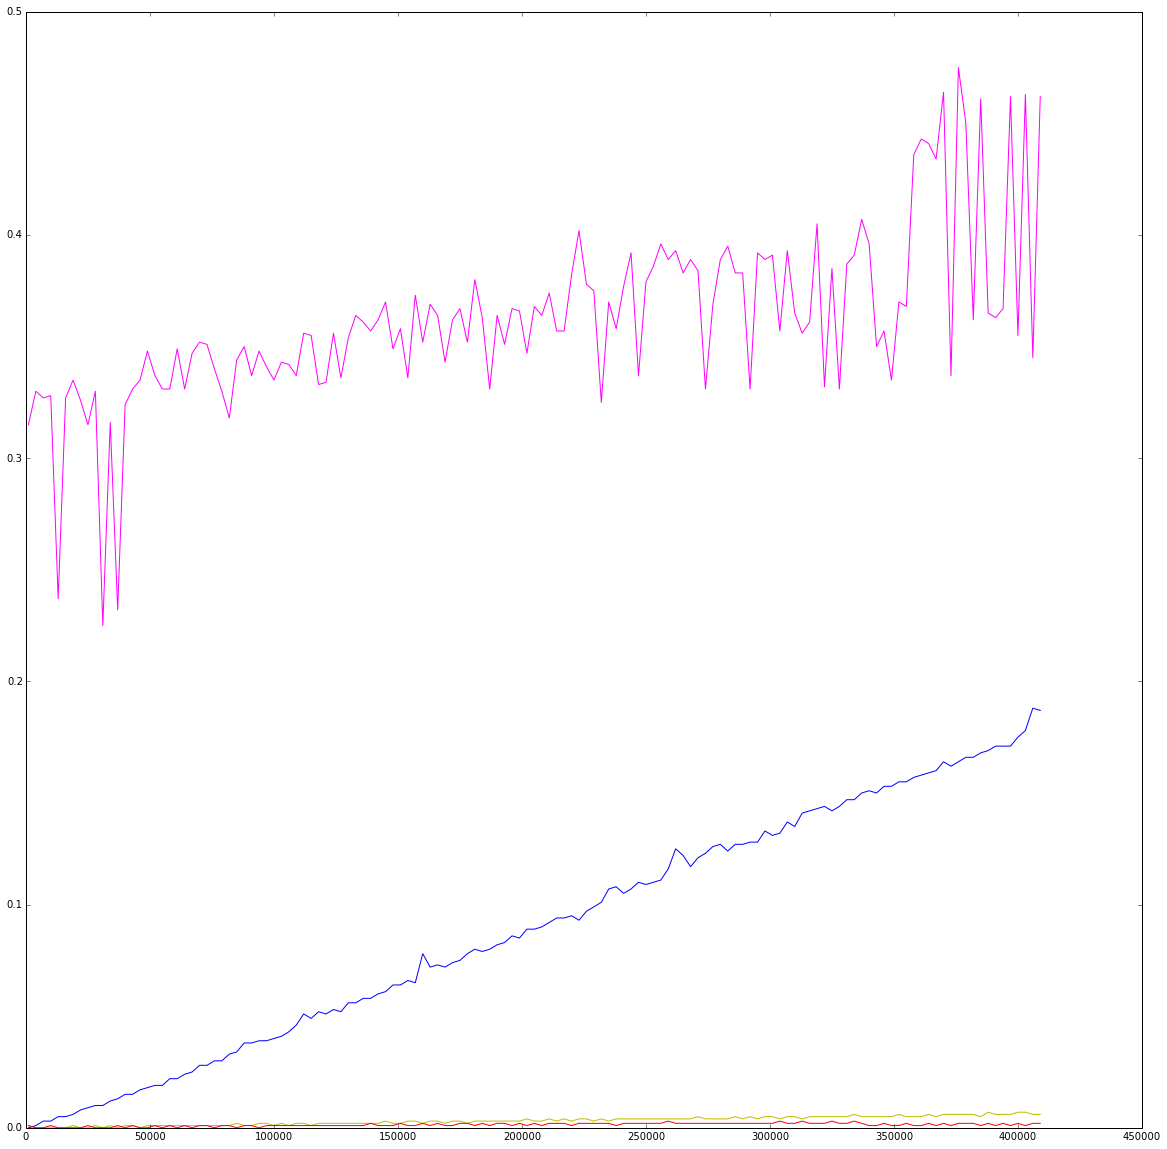

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

plt.plot(np.arange(1000,410100,3000),sumC,c='y')
plt.plot(np.arange(1000,410100,3000),sumP,c='b')
plt.plot(np.arange(1000,410100,3000),sumCP,c='r')
plt.plot(np.arange(1000,410100,3000),sumMP,c='magenta')
# plt.savefig("speedup.png",dpi=320)
# plt.xlim([1000,12000])

In [ ]:
# def csort(np.ndarray[np.int_t,ndim=1] a,np.ndarray[np.int_t,ndim=1] compar):
# #     qsort(<np.int_t*>a.data,compar, 0, a.shape[0])
#     insertion_sort(<np.int_t*>a.data,<np.int_t*>compar.data, 0, a.shape[0])
# cdef void qsort(np.int_t* a,np.ndarray[np.int_t,ndim=1] comp, Py_ssize_t start, Py_ssize_t end):
# #     print start ,end
#     if (end - start) <=1:
# #         insertion_sort(a,comp, start, end)
#         return
#     cdef Py_ssize_t boundary = partition(a,comp, start, end)
#     cdef int i
# #     print 'boundry',boundary,[a[i] for i in range(start,end)]
# #     return
#     qsort(a,comp, start, boundary)
#     qsort(a,comp, boundary+1, end)

# cdef Py_ssize_t partition(np.int_t* a,np.ndarray[np.int_t,ndim=1] comp, Py_ssize_t start, Py_ssize_t end):
#     assert end > start
#     cdef Py_ssize_t i = start, j = end-1
#     cdef np.int_t pivot = a[j]
#     while True:
#         # assert all(x < pivot for x in a[start:i])
#         # assert all(x >= pivot for x in a[j:end])

#         while compareA(a[i],pivot,comp)<0:
#             i += 1
#         while i < j and compareA(a[j],pivot,comp)>=0:
#             j -= 1
#         if i >= j:
#             break
       
#         swap(a, i, j)
        
    
#     swap(a, i, end-1)
#     assert a[i] == pivot
#     # assert all(x < pivot for x in a[start:i])
#     # assert all(x >= pivot for x in a[i:end])
#     return i

# cdef inline void swap(np.int_t* a, Py_ssize_t i, Py_ssize_t j):
# #     print 'swap', a[i],a[j]
#     a[i], a[j] = a[j], a[i]
# #     print 'swap', a[i],a[j]
            
    
    
# cdef void insertion_sort(np.int_t* a,np.int_t*comp, Py_ssize_t start, Py_ssize_t end):
#     cdef Py_ssize_t i, j
#     cdef np.int_t v
#     for i in range(start, end):
#         #invariant: [start:i) is sorted
#         v = a[i]; j = i-1
#         while j >= start:
#             if compareA(a[j],v,comp)<=0: break
#             a[j+1] = a[j]
#             j -= 1
#         a[j+1] = v

In [58]:
from multiprocessing import Pool,Process,cpu_count,Array
from sortSingle import sortSingle

#     return newL
def gend(a,step):
    for i in range(0,len(a),step):
        yield a[i:i+step]
def sortMultiP(i,baseL,deg):
    step=i//10
    stop=i-(i%step)
#     startstops=[start,start+step for start in range(0,i,step)]
#     pool = Pool()
#     res=pool.map(sortSingle, (baseL,start))
#     pool.close() 
#     pool.join()
    nnewL=np.zeros((baseL.shape[0],),dtype=int)
    newL=Array('i',nnewL)
    deg=Array('i',deg)
    jobs=[]
    for ar,nar in zip(gend(baseL,step),range(0,i,step)):
#         print ar,nar
        p=Process(target=sortSingle,args=(ar,newL,deg,nar))
        jobs.append(p)
        p.start()
#         print nar
    for j in jobs:
        j.join()
    return newL

np.random.seed(1)
nn=120
a=np.random.randint(0,5,(nn,))
print a
comp=np.array([5,1,2,3,7])
print sortMultiP(120,a,comp)[:]

[3 4 0 1 3 0 0 1 4 4 1 2 4 2 4 3 4 2 4 2 4 1 1 0 1 1 1 1 0 4 1 0 0 3 2 1 0
 3 1 1 3 4 0 1 3 4 2 4 0 3 1 2 0 4 1 2 2 1 0 1 3 4 3 1 3 0 0 2 2 1 3 4 2 0
 0 1 1 3 0 0 4 2 4 3 3 0 3 4 3 4 4 4 1 0 4 2 0 2 4 1 1 0 2 4 4 0 4 1 4 1 0
 2 3 1 2 4 4 2 2 0]
[1, 1, 1, 2, 3, 3, 0, 0, 0, 4, 4, 4, 1, 1, 2, 2, 2, 3, 0, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 3, 0, 0, 0, 4, 1, 1, 1, 2, 3, 3, 3, 0, 0, 4, 4, 4, 1, 1, 1, 1, 2, 2, 2, 3, 0, 0, 0, 4, 1, 1, 2, 2, 3, 3, 3, 3, 0, 0, 4, 4, 1, 1, 2, 2, 3, 3, 0, 0, 0, 0, 4, 4, 1, 2, 3, 3, 3, 0, 0, 4, 4, 4, 4, 4, 1, 1, 1, 2, 2, 0, 0, 0, 4, 4, 4, 4, 1, 1, 2, 2, 2, 2, 3, 0, 0, 4, 4, 4]


In [ ]:
%%cython -I E:/work_projects/graphlets/graphlet_pyFramework --compile-args=-fopenmp --link-args=-fopenmp --cplus

cimport numpy as np
import numpy as np
import time
from cython.parallel import prange

from cpython cimport array
import array
DEF CUTOFF = 17
DEF MAXDEGREE=10

cdef compareA(np.int_t a,np.int_t b,np.int_t*comp):
    return comp[a]-comp[b]



cdef sth( np.ndarray[np.int_t , ndim=1] a,int start,int end, np.ndarray[np.int_t , ndim=1] deg,int maxD):
    cdef np.ndarray[np.int_t , ndim=1]  newA=np.zeros((end-start,),dtype=np.int)
    
    
    cdef int i
    cdef int minDeg=18585682356,maxDeg=0
    for i in range(start,end):
        if deg[a[i]]>maxDeg:
            maxDeg=deg[a[i]]
    cdef np.ndarray[np.int_t , ndim=1]  degreeCnt=np.zeros((maxDeg+1,),dtype=np.int)
#     print 'maxDeg',maxDeg
    for i in range(start,end):
        degreeCnt[deg[a[i]] ]+=1
        if deg[a[i]]<minDeg:
            minDeg=deg[a[i]]
#     print 'degree Cnt',degreeCnt,minDeg
    
    cdef int work=0,tempDeg=0
    for i in range(minDeg,maxDeg):
        tempDeg=degreeCnt[i]
        degreeCnt[i]=work
        work+=tempDeg
       
#      print 'degree Cnt',degreeCnt,end-start
    for i in range(start,end):
        newA[degreeCnt[ deg[a[i]] ] ]=a[i]
        degreeCnt[ deg[a[i]] ] +=1
    return newA

cdef extern from "alloc_int.c":
    int* alloc_int(int n) nogil

cdef extern from "alloc_int.c":
    void free_int(int* n) nogil

cdef void sthP( int[:] a,int start,int end,int[:] deg,
         int[:] newA) nogil:
    cdef int i
    cdef int minDeg=18585682356,maxDeg=0
    for i in range(start,end):
        if deg[a[i]]>maxDeg:
            maxDeg=deg[a[i]]
        if deg[a[i]]<minDeg:
            minDeg=deg[a[i]]
    maxDeg+=1
    cdef int* degreeCnt=alloc_int(maxDeg)
    for i in range(minDeg,maxDeg):
        degreeCnt[i]=0
#     print 'min/maxDeg',minDeg, maxDeg
    for i in range(start,end):
        degreeCnt[deg[a[i]] ]+=1
    
#     print 'degree Cnt',degreeCnt,minDeg
    
    cdef int work=0,tempDeg=0
    for i in range(minDeg,maxDeg):
        tempDeg=degreeCnt[i]
        degreeCnt[i]=work
        work+=tempDeg
       
#      print 'degree Cnt',degreeCnt,end-start
    for i in range(start,end):
        newA[degreeCnt[ deg[a[i]] ] ]=a[i]
        degreeCnt[ deg[a[i]] ] +=1
    free_int(degreeCnt)
#     return newA
cdef void callS(int[:] a,int[:] comp,int [:] newA,
                    ):
    cdef int in_i,stop,step,to_in_i
    stop=i-(i%(i//10))
    step=i//10
    
    
    
#     cdef np.int_t* cnewA=<np.int_t*>newA.data
    
#     printA=np.asarray(<np.int_t[:len(newA)]> cnewA)
#     print printA[:100]
    for in_i in prange(0,stop,step,nogil=True):
        sthP(a,in_i,in_i+step,comp,newA[in_i:in_i+step])
#         print a[in_i:in_i+step],printA[in_i:in_i+step]
#         print 'stop step',in_i,in_i+step


from multiprocessing import Pool,Process,cpu_count,Array
from sortSingle import *

#     return newL
def gend(a,step):
    for i in range(0,len(a),step):
        yield a[i:i+step]
def sortMultiP(i,baseL,deg):
    step=i//10
    stop=i-(i%step)
#     startstops=[start,start+step for start in range(0,i,step)]
#     pool = Pool()
#     res=pool.map(sortSingle, (baseL,start))
#     pool.close() 
#     pool.join()
    nnewL=np.zeros((baseL.shape[0],),dtype=int)
    newL=Array('i',nnewL)
    deg=Array('i',deg)
    jobs=[]
    for ar,nar in zip(gend(baseL,step),range(0,i,step)):
#         print ar,nar
        p=Process(target=sortSingle,args=(ar,newL,deg,nar))
        jobs.append(p)
        p.start()
#         print nar
    for j in jobs:
        j.join()
    return newL



np.random.seed(1)
nn=561000
a=np.random.randint(0,5,(nn,))

comp=np.array([5,1,2,3,7])
sumC,sumP,sumCP=[],[],[]


    
i=121000

print a



newA=np.zeros((i,),dtype=np.int)


ap=[]
for in_i in range(0,i-(i%(i//10)),i//10):
    ap.extend(sorted(a[in_i:in_i+(i//10)],key=lambda x: comp[x]))
    print 'stop step',in_i,in_i+(i//10)

callS(a,comp,newA)

# multiPA=sortMultiP(120,a,comp)

# # print 'a, print a , ap:',a,printA,ap
# print 'py_code_vs_cParalel(0):{};pycode_vs_pymultiP(0):{}'.format(np.sum([p!=cp for p,cp in zip(ap,newA)]),
#                                            np.sum([p!=cp for p,cp in zip(ap,multiPA)]))

[3 4 0 ..., 1 3 0]


In [8]:
from multiprocessing import Pool,Process,cpu_count,Array
from sortSingle import *

#     return newL
def gend(a,step):
    for i in range(0,len(a),step):
        yield a[i:i+step]


def sortMultiPMap(i,baseL,deg):
    step=i//10
    stop=i-(i%step)
#     startstops=[start,start+step for start in range(0,i,step)]
#     pool = Pool()
#     res=pool.map(sortSingle, (baseL,start))
#     pool.close() 
#     pool.join()
    newL=np.zeros((baseL.shape[0],),dtype=int)
    pool=Pool()
    results=pool.map(sortSingleMap, zip(gend(baseL,step),gend(newL,step) ))
    pool.close() 
    pool.join()
    resL=[]
    for i in results:
        resL.extend(i)
#     print 'results',results
    return resL
np.random.seed(1)
nn=561000
a=np.random.randint(0,5,(nn,))

comp=np.array([5,1,2,3,7])

i=121000

amp=sortMultiPMap(i,a[:i],comp)

ap=[]
for in_i in range(0,i-(i%(i//10)),i//10):
    ap.extend(sorted(a[in_i:in_i+(i//10)],key=lambda x: comp[x]))
    print 'stop step',in_i,in_i+(i//10)

print 'py_code_vs_pyMPParallel(0):{}'.format(np.sum([p!=cp for p,cp in zip(ap,amp)]),
#                                            np.sum([p!=cp for p,cp in zip(ap,multiPA)])
)

stop step 0 12100
stop step 12100 24200
stop step 24200 36300
stop step 36300 48400
stop step 48400 60500
stop step 60500 72600
stop step 72600 84700
stop step 84700 96800
stop step 96800 108900
stop step 108900 121000
py_code_vs_pyMPParallel(0):0


In [20]:
%%cython -I E:/work_projects/graphlets/graphlet_pyFramework --compile-args=-fopenmp --link-args=-fopenmp --cplus 

cdef extern from "alloc_int.c":
    int* alloc_int(int n) nogil

cdef extern from "alloc_int.c":
    void free_int(int* n) nogil

In [2]:
import os
os.environ['PATH']

'C:\\Users\\Kiks\\Miniconda3\\envs\\py2\\Library\\bin;C:\\Users\\Kiks\\Miniconda3\\envs\\py2\\Library\\bin;E:\\programs\\tdm_gcc4.7\\bin;C:\\PROGRA~1\\NVIDIA~2\\CUDA\\v7.5\\bin;C:\\PROGRA~1\\NVIDIA~2\\CUDA\\v7.5\\libnvvp;;;C:\\PROGRA~1\\ImageMagick-6.9.0-Q16;C:\\PROGRA~1\\Common Files\\Microsoft Shared\\Windows Live;C:\\PROGRA~2\\Common Files\\Microsoft Shared\\Windows Live;C:\\ProgramData\\Oracle\\Java\\javapath;C:\\PROGRA~2\\Intel\\iCLS Client\\;C:\\PROGRA~1\\Intel\\iCLS Client\\;C:\\Windows\\system32;C:\\Windows;C:\\Windows\\System32\\Wbem;C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\;C:\\PROGRA~1\\Intel\\Intel(R) Management Engine Components\\DAL;C:\\PROGRA~2\\Intel\\Intel(R) Management Engine Components\\DAL;C:\\PROGRA~1\\Intel\\Intel(R) Management Engine Components\\IPT;C:\\PROGRA~2\\Intel\\INTEL(~1\\IPT;C:\\PROGRA~2\\Autodesk\\Backburner\\;C:\\PROGRA~2\\Windows Live\\Shared;C:\\PROGRA~2\\Git\\cmd;C:\\PROGRA~2\\Windows Kits\\8.1\\Windows Performance Toolkit\\;C:\\PROGRA~1\\Mic